# Classes detections

In [12]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [20]:
WIDTH, HEIGHT = 28, 28
EPOCHS = 20

resources_folder = 'resources'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

loaded numpy bitmaps, 8 classes


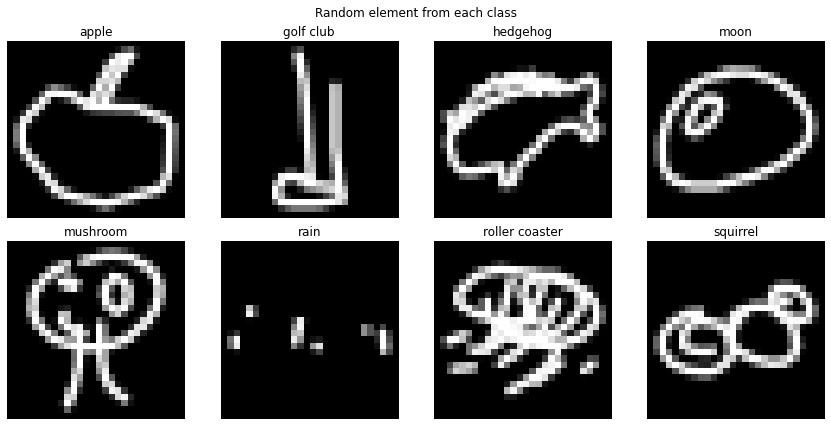

In [27]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dir: str, width: int=128, height: int=128):
        super().__init__()

        assert width==height
        self.size = (width, height)

        self._get_data(dir)
        self.data = [self._convert_img_to_np_arrays(path) for path in self.data_paths]
        
        
    def _get_data(self, dir):
        self.data_paths = []
        self.labels = []

        for sub_dir, label in zip(os.listdir(dir), [0,1]):
            self.data_paths += [dir+"/"+sub_dir+"/"+img for img in os.listdir(dir+"/"+sub_dir)]
            self.labels += [label]*len(os.listdir(dir+"/"+sub_dir))
        self.data_paths=np.array(self.data_paths)
        self.labels=np.array(self.labels)

    def _convert_img_to_np_arrays(self, img_path):
        from PIL import Image

        image = Image.open(img_path)

        # we resize images so they all have the same shape
        resized_image = image.resize(self.size)

        # we normalize images so all values are between 0 and 1
        np_image = np.array(resized_image, dtype=float)/255.0

        np_image = np_image.astype(np.float32)

        # we transpose the matrix so it follows "channel first" convention
        np_image = np.transpose(np_image, (2, 0, 1))

        return np_image

    def __getitem__(self, key: int):
        assert key < self.__len__()

        img = self.data[key]
        label = self.labels[key]

        return img, label

    
    def __len__(self):
        return len(self.data)

In [ ]:

training_set = CustomDataset("")
validation_set = CustomDataset("")

#################################################################

batch_size: int = 32

training_loaded_set = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=batch_size , shuffle=True)

In [ ]:
def plot_loss_and_accuracy_per_epoch(model):
    plt.plot(model.nb_epochs, model.loss_history)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('loss per epoch')
    plt.show()

    plt.plot(model.nb_epochs, model.train_acc_history, label='training')
    plt.plot(model.nb_epochs, model.valid_acc_history, label='validation')
    plt.ylabel('accuracy in %')
    plt.xlabel('epoch')
    plt.ylim(0, 100)
    plt.title('accuracy per epoch')
    plt.legend()
    plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self, width: int, height: int):
        super().__init__()

        filter_size: int = 5
        self.conv1 = nn.Conv2d(3, 6, filter_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, filter_size)

        shape_after_conv = int((((width-4)/2)-4)/2)
        
        self.fc1 = nn.Linear(16 * shape_after_conv * shape_after_conv, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        input = self.forward(x)
        m = nn.Softmax(dim=1)
        return m(input)



model = Net(128, 128)
print(model)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(f'number of trainable parameters : {sum([np.prod(p.size()) for p in model_parameters])}')

In [ ]:
class GPUNet(Net):
    def __init__(self, width: int, height: int, device):
        super().__init__(width, height)
        self._device = device

    def fit(self, train_loader, valid_loader, nb_epochs:int =10):
        self.loss_history = []
        self.train_acc_history = []
        self.valid_acc_history = []

        self.nb_epochs = [epoch+1 for epoch in range(nb_epochs)]

        import torch.optim as optim
        
        optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

        criterion = nn.CrossEntropyLoss()

        start_time = time.time()

        for epoch in self.nb_epochs:

            running_loss = 0.0
            nb_batch = 0

            for i, data in enumerate(train_loader, start=0):
                nb_batch+=1
                inputs, labels = data
                inputs, labels = inputs.to(self._device), labels.to(self._device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.forward(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
            running_loss/=nb_batch
            train_acc = self.compute_accuracy(train_loader)*100
            valid_acc = self.compute_accuracy(valid_loader)*100
            
            print(f'epoch [{epoch}/{len(self.nb_epochs)}], loss : {running_loss}, train acc : {round(train_acc,3)}%, valid acc : {round(valid_acc,3)}%')
            self.loss_history.append(running_loss)
            self.train_acc_history.append(train_acc)
            self.valid_acc_history.append(valid_acc)
                    
        print('Finished Training')

        end_time = time.time()
        self.training_time = end_time - start_time

    def compute_accuracy(self, dataset: DataLoader):
        correct, total = 0, 0

        for data in dataset:
            inputs, labels = data
            inputs, labels = inputs.to(self._device), labels.to(self._device)

            outputs = self.predict(inputs)
            _, predicted_classes = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted_classes == labels).sum().item()

        return correct/total
    

In [ ]:

class VGG16FeatureExtractor(GPUNet):
    def __init__(self, width: int, height: int, device):
        super(VGG16FeatureExtractor, self).__init__(width, height, device)

        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # set vgg16 layers to not trainable
        for param in vgg16.parameters():
            param.requires_grad = False

        self.features = vgg16.features
        self.avgpool = vgg16.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def fit(self, train_loader, valid_loader, nb_epochs:int =10):
        self.loss_history = []
        self.train_acc_history = []
        self.valid_acc_history = []
        
        self.nb_epochs = [epoch+1 for epoch in range(nb_epochs)]

        import torch.optim as optim
        
        optimizer = optim.SGD(self.classifier.parameters(), lr=0.01, momentum=0.9)

        criterion = nn.CrossEntropyLoss()

        start_time = time.time()

        for epoch in self.nb_epochs:

            running_loss = 0.0
            nb_batch = 0

            for i, data in enumerate(train_loader, start=0):
                nb_batch+=1
                inputs, labels = data
                inputs, labels = inputs.to(self._device), labels.to(self._device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.forward(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
            running_loss/=nb_batch
            train_acc = self.compute_accuracy(train_loader)*100
            valid_acc = self.compute_accuracy(valid_loader)*100
            
            print(f'epoch [{epoch}/{len(self.nb_epochs)}], loss : {running_loss}, train acc : {round(train_acc,3)}%, valid acc : {round(valid_acc,3)}%')
            self.loss_history.append(running_loss)
            self.train_acc_history.append(train_acc)
            self.valid_acc_history.append(valid_acc)
                    
        print('Finished Training')

        end_time = time.time()
        self.training_time = end_time - start_time


In [1]:
vgg16_model = VGG16FeatureExtractor(WIDTH, HEIGHT, device)

total_params = sum(p.numel() for p in vgg16_model.parameters())
print(f"Total number of parameters: {total_params}")

vgg16_model.to(device)
vgg16_model.fit(augmented_training_loaded_set, validation_loaded_set, nb_epochs=5)

NameError: name 'VGG16FeatureExtractor' is not defined

In [ ]:
plot_loss_and_accuracy_per_epoch(vgg16_model)

print(f'training accuracy : {vgg16_model.compute_accuracy(training_loaded_set)*100} %')
print(f'validaiton accuracy : {vgg16_model.compute_accuracy(validation_loaded_set)*100} %')